# Predicting Breast Cancer With Multiple Classification Algorithms

## Imports

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score
)
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_validate,
    train_test_split
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Introduction

### Summary

In this project, we perform data analysis to look for the most efficient model to predict whether it is benign and malignant tumour based on different measurements/traits observed from the data. We use various machine learning algorithms that classify whether a breast tumour is malignant or benign accordingly, and eventually decide on the best algorithm for that task based on recall score. The dataset is obtained from https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29


### Background

Breast cancer is the development of cancerous tissue of the breast. A malignant (cancerous) tumour can destroy other healthy tissue surroungding it and the disease could potentially metastasize, causing numerous other health complications. However, a tumour might or might not be cancerous. A benign (non-cancerous) tumour will not cause as much harm to the patient compared to a malignant one. With that in mind, an early diagnosis of a **malignant tumour** would give both patients and health care providers valuable time to quickly devise various treatment plans to stop the progression of the disease. This is important especially for a silent killer like cancer, in which the earlier a correct diagnosis has been made, the drastically better the prognosis.
This raises the question:

**Can we predict whether a tumor is malignant or benign based  on the different features observed from the tumour?**

### Dataset Description

The dataset we use: Breast Cancer Wisconsin (Original) Data Set, created by Dr. WIlliam H. Wolberg (physician), contains the following features with 699 observations:

1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10

With the relevant target class:

11. Class: (2 for benign, 4 for malignant)

## Exploratory Data Analysis

Since the dataset did not come with column headers, we will first manually add them and load data. The headers will correspond to the order of their respective description above.

In [2]:
col_names = ["id", "clump", "unif_size", "unif_shape", "adhesion", "epi_size",
             "nuclei", "chromatin", "nucleoli", "mitoses", "class"]

dataset = pd.read_csv("data/breast_cancer.txt", names=col_names, sep=",")

In [3]:
dataset.head()

,id,clump,unif_size,unif_shape,adhesion,epi_size,nuclei,chromatin,nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          699 non-null    int64 
 1   clump       699 non-null    int64 
 2   unif_size   699 non-null    int64 
 3   unif_shape  699 non-null    int64 
 4   adhesion    699 non-null    int64 
 5   epi_size    699 non-null    int64 
 6   nuclei      699 non-null    object
 7   chromatin   699 non-null    int64 
 8   nucleoli    699 non-null    int64 
 9   mitoses     699 non-null    int64 
 10  class       699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


We see that the dataset uses "?" for missing data so we eliminate rows that contain "?". As shown above, all of the variables are numeric except for variables nuclei, we decide to transform it into type int for ease of data analysis later on. Finally, "id" feature does not appear to be useful for the prediction task; hence, it is dropped before carrying on to further analysis. 

In [5]:
dataset = dataset[(dataset != '?').all(axis=1)]
dataset['nuclei'] = dataset['nuclei'].astype(int)
dataset = dataset.drop(columns=["id"])

We also decide to replace benign class from 2 to 0 and malignant class from 4 to 1 since if we keep values of 2 and 4, it would be hard for predictive models to calculate accuracy, precision, and so on. 

In [6]:
dataset['class'] = dataset['class'].replace([2],0)
dataset['class'] = dataset['class'].replace([4],1) 
dataset['class'].value_counts(normalize = True)
  

0    0.650073
1    0.349927
Name: class, dtype: float64

There is an imbalance in the dataset between benign and malignant. We want to further investigate the malignant examples (class = 4); hence the classes should have same importance so recall would be the most appropriate and main metric for this project. This is due to the fact that in a medical diagnosis setting, false negative result for a disease like cancer will cause a lot more harm than a false positive result.

Then we split the data into training and testing sets (X_train, X_test, y_train, y_test) and extract names of numeric features for further exploration. 
 

In [7]:
train_df, test_df = train_test_split(dataset, test_size=0.3, random_state=123)
X_train = train_df.drop(columns=["class"])
X_test = test_df.drop(columns=["class"])

y_train = train_df["class"]
y_test = test_df["class"]
numeric_looking_columns = X_train.select_dtypes(include=np.number).columns.tolist()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478 entries, 696 to 525
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   clump       478 non-null    int64
 1   unif_size   478 non-null    int64
 2   unif_shape  478 non-null    int64
 3   adhesion    478 non-null    int64
 4   epi_size    478 non-null    int64
 5   nuclei      478 non-null    int32
 6   chromatin   478 non-null    int64
 7   nucleoli    478 non-null    int64
 8   mitoses     478 non-null    int64
 9   class       478 non-null    int64
dtypes: int32(1), int64(9)
memory usage: 39.2 KB


In [31]:
benign_cases = train_df[train_df["class"] == 0]
                    
malignant_cases = train_df[train_df["class"] == 1]

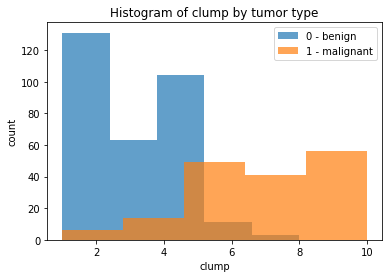

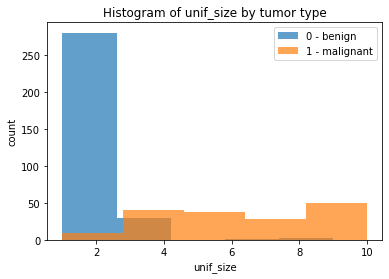

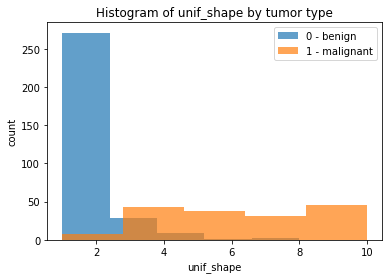

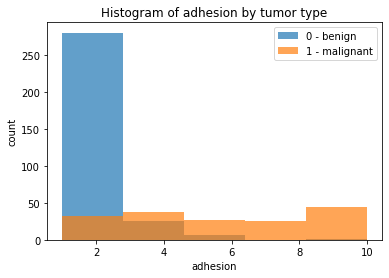

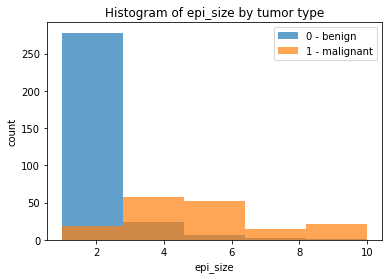

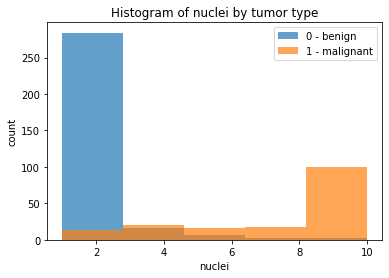

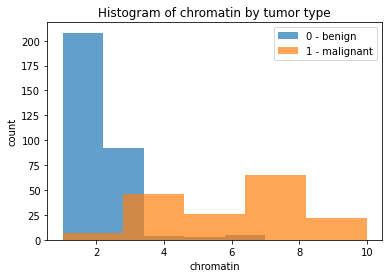

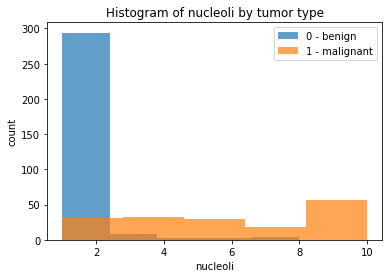

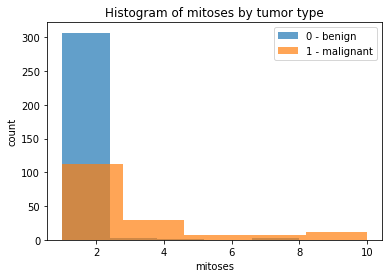

In [35]:
for x in numeric_looking_columns:
    plt.hist(benign_cases[x], alpha=0.7, bins=5, label="0 - benign")
    plt.hist(malignant_cases[x], alpha=0.7, bins=5, label="1 - malignant")
    plt.legend(loc="best")

    plt.xlabel(x)
    plt.ylabel("count")
    plt.title(f"Histogram of {x} by tumor type")
    plt.show()

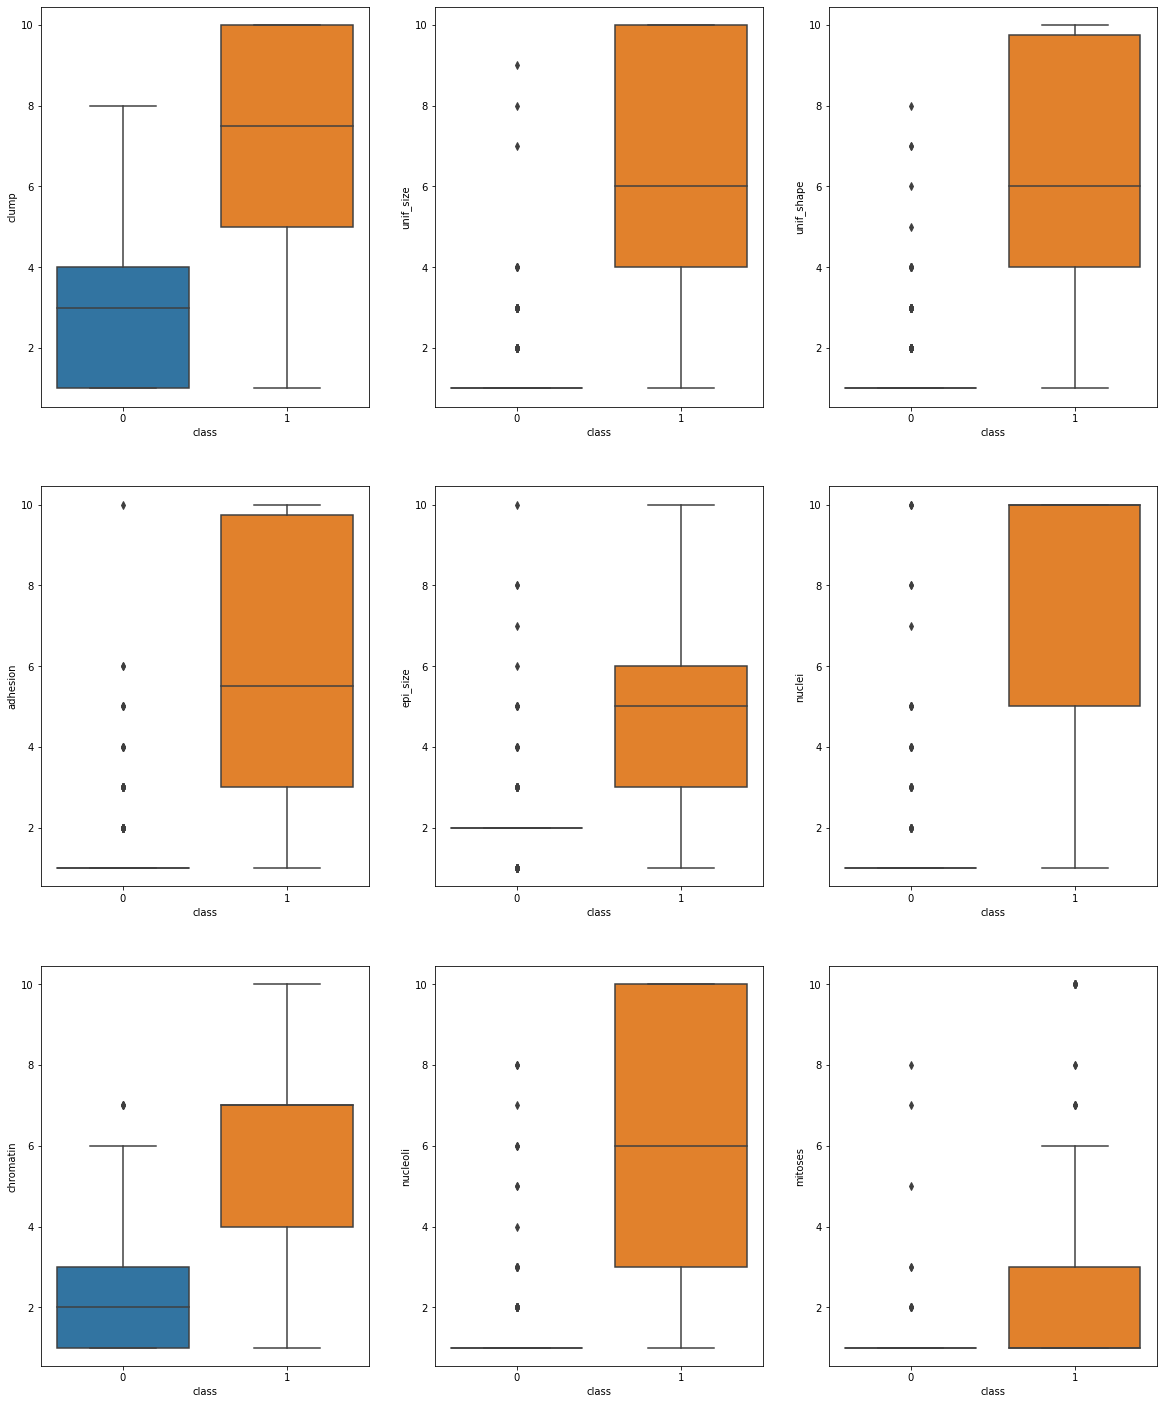

In [37]:
fig, ax = plt.subplots(3, 3, figsize=(20, 25))
for var, subplot in zip(numeric_looking_columns, ax.flatten()):
    sns.boxplot(x='class', y=var, data=train_df, ax=subplot)

*Comments on above plots:*





## Preprocessing 

Since all features are numeric, we decide to scale our data as so to ensure that there is no bias present when predicting results. 

In [10]:
numeric_transformer = StandardScaler()
ct = make_column_transformer(
    (numeric_transformer, numeric_looking_columns))

## Data analysis 

Even though the main score we will be comparing when choosing the models is recall, we still want to look into accuracy and decision. Because between a model performs well on recall but have very low accuracy and precision versus a model performs just a bit worse on recall but have excellent accuracy and precision, the latter model will still have an upper hand. 

In [11]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]

We create a function which applies the given model for X_train, y_train and then returns mean and std of cross-validation scores. 

We decide to test 3 models: Decision Tree, kNN and Logistic Regression. Decision Tree, kNN, Logistic Regression are simple models with fast fit_time and moderate precision and accuracy and suitable for the prediction task.


In [12]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [13]:
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
pipe_knn = make_pipeline(ct,KNeighborsClassifier())
pipe_reg = make_pipeline(ct, LogisticRegression(max_iter=100000))

classifiers = {
    "Decision Tree": pipe_dt,
    "kNN": pipe_knn,
    "Logistic Regression" : pipe_reg
}

results = {}

for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, 
        X_train, 
        y_train, 
        return_train_score=True, 
        scoring = scoring
    )

pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
Decision Tree,0.008 (+/- 0.005),0.002 (+/- 0.002),0.952 (+/- 0.016),1.000 (+/- 0.000),0.930 (+/- 0.023),1.000 (+/- 0.000),0.927 (+/- 0.041),1.000 (+/- 0.000),0.935 (+/- 0.034),1.000 (+/- 0.000)
kNN,0.005 (+/- 0.003),0.005 (+/- 0.006),0.964 (+/- 0.012),0.971 (+/- 0.004),0.949 (+/- 0.018),0.959 (+/- 0.006),0.952 (+/- 0.027),0.964 (+/- 0.011),0.946 (+/- 0.013),0.954 (+/- 0.006)
Logistic Regression,0.008 (+/- 0.005),0.005 (+/- 0.004),0.964 (+/- 0.009),0.967 (+/- 0.005),0.949 (+/- 0.014),0.952 (+/- 0.007),0.946 (+/- 0.026),0.949 (+/- 0.010),0.952 (+/- 0.016),0.955 (+/- 0.005)


As shown above, kNN model is the best performing model with the highest test_recall score, 0.952, and high test_precision and test_accuracy, 0.946 and 0.964 respectively. Even though Logistics Regression has higher precision score, its fit_time is larger and recall score is lower than those of kNN so overall, Logistics Regression model still performs worse in this case.

After choosing the most efficient model, we move onto tuning the hyperparameters for the model to increase its performance. We decide to tune n_neighbors which determines the number of neighbors k and weights which determines weight function used in prediction. 

In [38]:
search = GridSearchCV(pipe_knn,
                      param_grid={'kneighborsclassifier__n_neighbors': range(1, 50),
                                  'kneighborsclassifier__weights': ['uniform', 'distance']},
                      cv=10, 
                      n_jobs=-1,  
                      scoring="recall", 
                      return_train_score=True)
search.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

0.9639705882352942
{'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'uniform'}


The results above shows with n_neighbors: 5, weights': 'uniform, the model would achieve its highest performance with the recall score of 0.9640. 

## Model on test set 

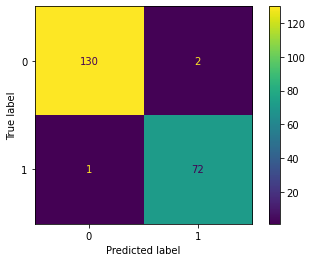

In [69]:
pipe_knn_tuned = make_pipeline(ct,KNeighborsClassifier(n_neighbors =5, weights ='uniform'))
pipe_knn_tuned.fit(X_train, y_train)
pipe_knn_tuned.score(X_test, y_test)

predictions = pipe_knn_tuned.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=pipe_knn_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_knn_tuned.classes_)
disp.plot()


After applying the model to the test set, we obtain the score of 0.985 which indicates that this model generalizes well for prediction task. 

## Summary of results and discussion  

In [70]:
print(
    classification_report(
        y_test, pipe_knn_tuned.predict(X_test), target_names=["benign", "malignant"]
    )
)

              precision    recall  f1-score   support

      benign       0.99      0.98      0.99       132
   malignant       0.97      0.99      0.98        73

    accuracy                           0.99       205
   macro avg       0.98      0.99      0.98       205
weighted avg       0.99      0.99      0.99       205



*Summary of Findings:* 

*Impacts of our Findings:* 

*Future Questions:* 